In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Este notebook vive en /proyecto-2-control-inventarios/notebooks
BASE = Path('..')
DATA = BASE / 'data'
REPORTS = BASE / 'reports'
REPORTS.mkdir(exist_ok=True)

DATA, REPORTS

(WindowsPath('../data'), WindowsPath('../reports'))

In [2]:
%matplotlib inline

In [3]:
df_inv = pd.read_csv(DATA / 'inventario_movimientos.csv')         # entradas / salidas por insumo
df_rec = pd.read_csv(DATA / 'recetas.csv')                        # receta por platillo
df_ven = pd.read_csv(Path('..') / '..' / 'proyecto-1-dashboard-ventas' / 'data' / 'ventas_sucursales.csv')  # ventas

df_inv.head()


,fecha,sucursal,insumo,unidad,entrada,salida,costo_unitario_mxn
0,2025-06-01,Centro,Carne de res,kg,20,12,160.0
1,2025-06-01,Centro,Lechuga,pz,30,18,8.0
2,2025-06-01,Centro,Pan para hamburguesa,pz,100,60,3.5
3,2025-06-02,Norte,Papas,kg,25,15,25.0
4,2025-06-02,Norte,Aceite,lt,10,6,45.0


In [4]:
df_rec.head()


,platillo,insumo,unidad,cantidad_por_platillo
0,Hamburguesa Clásica,Carne de res,kg,0.18
1,Hamburguesa Clásica,Pan para hamburguesa,pz,1.00
2,Ensalada César,Lechuga,pz,0.50
3,Papas Fritas,Papas,kg,0.25
4,Papas Fritas,Aceite,lt,0.03


In [5]:
df_ven.head()

,fecha,sucursal_id,sucursal,hora,platillo,categoria,cantidad,precio_unitario_mxn,total_mxn
0,2025-06-01,SUC-01,Centro,12:00,Hamburguesa Clásica,Comidas,3,95,285
1,2025-06-01,SUC-01,Centro,13:00,Papas Fritas,Acompañamientos,5,35,175
2,2025-06-01,SUC-02,Norte,19:00,Tacos de Arrachera,Comidas,4,110,440
3,2025-06-02,SUC-03,Sur,09:00,Café Americano,Bebidas,10,29,290
4,2025-06-02,SUC-04,Río,21:00,Malteada Vainilla,Bebidas,2,55,110


In [6]:
# Unidades vendidas por platillo (puedes filtrar un periodo si quieres)
ventas_por_platillo = (
    df_ven.groupby('platillo', as_index=False)['cantidad']
          .sum()
          .rename(columns={'cantidad':'unidades_vendidas'})
)

ventas_por_platillo.head()



,platillo,unidades_vendidas
0,Alitas BBQ,6
1,Café Americano,10
2,Ensalada César,2
3,Hamburguesa Clásica,8
4,Malteada Vainilla,2


In [7]:
# Recetas: (platillo, insumo, unidad, cantidad_por_platillo)
consumo_teorico = (
    df_rec.merge(ventas_por_platillo, on='platillo', how='left')
          .fillna({'unidades_vendidas':0})
)
consumo_teorico['consumo_teorico'] = consumo_teorico['cantidad_por_platillo'] * consumo_teorico['unidades_vendidas']

# Consumo teórico agregado por insumo y unidad
consumo_teorico_insumo = (
    consumo_teorico.groupby(['insumo','unidad'], as_index=False)['consumo_teorico']
                   .sum()
)

consumo_teorico_insumo.head()



,insumo,unidad,consumo_teorico
0,Aceite,lt,0.36
1,Carne de res,kg,1.44
2,Lechuga,pz,1.00
3,Pan para hamburguesa,pz,8.00
4,Papas,kg,3.00


In [8]:
consumo_real = (
    df_inv.groupby(['insumo','unidad'], as_index=False)
          .agg(salida_real=('salida','sum'),
               costo_promedio=('costo_unitario_mxn','mean'))  # aproximación
)
consumo_real.head()


,insumo,unidad,salida_real,costo_promedio
0,Aceite,lt,6,45.0
1,Carne de res,kg,12,160.0
2,Lechuga,pz,18,8.0
3,Pan para hamburguesa,pz,60,3.5
4,Papas,kg,15,25.0


In [9]:
df_merma = consumo_teorico_insumo.merge(consumo_real, on=['insumo','unidad'], how='outer').fillna(0)

# Evitar división por cero
df_merma['consumo_teorico_aj'] = df_merma['consumo_teorico'].replace(0, np.nan)

df_merma['merma_unidades'] = df_merma['salida_real'] - df_merma['consumo_teorico']
df_merma['merma_%'] = (df_merma['merma_unidades'] / df_merma['consumo_teorico_aj']) * 100
df_merma['merma_%'] = df_merma['merma_%'].replace([np.inf, -np.inf], np.nan)

# Costo aproximado de merma
df_merma['costo_merma_mxn'] = df_merma['merma_unidades'] * df_merma['costo_promedio']

df_merma_sorted = df_merma.sort_values(['costo_merma_mxn'], ascending=False)
df_merma_sorted.head(10)


,insumo,unidad,consumo_teorico,salida_real,costo_promedio,consumo_teorico_aj,merma_unidades,merma_%,costo_merma_mxn
1,Carne de res,kg,1.44,12,160.0,1.44,10.56,733.333333,1689.6
4,Papas,kg,3.00,15,25.0,3.00,12.00,400.000000,300.0
0,Aceite,lt,0.36,6,45.0,0.36,5.64,1566.666667,253.8
3,Pan para hamburguesa,pz,8.00,60,3.5,8.00,52.00,650.000000,182.0
2,Lechuga,pz,1.00,18,8.0,1.00,17.00,1700.000000,136.0


In [10]:
resumen = {
    'insumos_con_mayor_merma_por_costo': df_merma_sorted[['insumo','unidad','costo_merma_mxn']].head(5),
    'insumos_con_mayor_merma_%': df_merma.sort_values('merma_%', ascending=False)[['insumo','unidad','merma_%']].head(5),
}
resumen


{'insumos_con_mayor_merma_por_costo':                  insumo unidad  costo_merma_mxn
 1          Carne de res     kg           1689.6
 4                 Papas     kg            300.0
 0                Aceite     lt            253.8
 3  Pan para hamburguesa     pz            182.0
 2               Lechuga     pz            136.0,
 'insumos_con_mayor_merma_%':                  insumo unidad      merma_%
 2               Lechuga     pz  1700.000000
 0                Aceite     lt  1566.666667
 1          Carne de res     kg   733.333333
 3  Pan para hamburguesa     pz   650.000000
 4                 Papas     kg   400.000000}

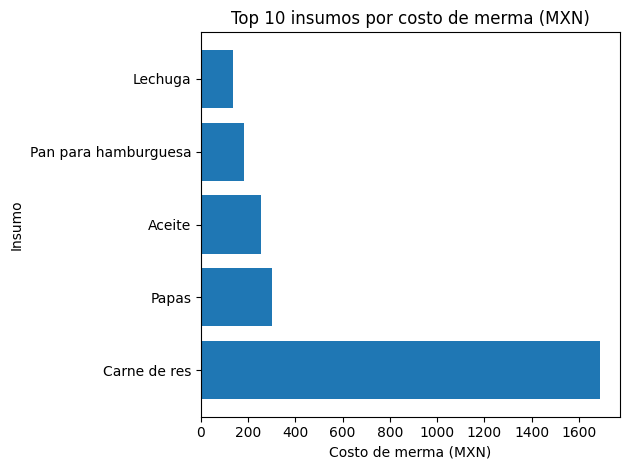

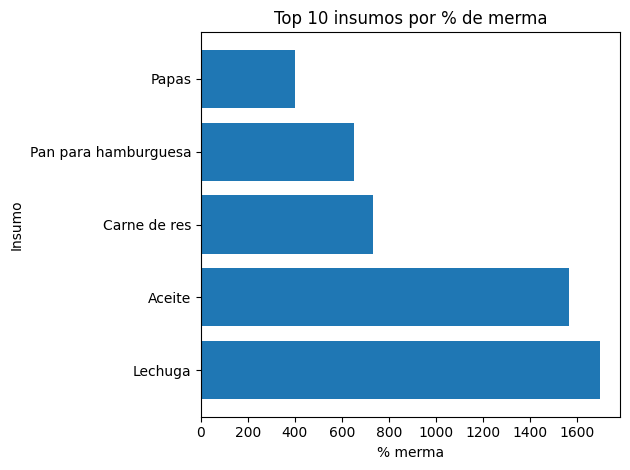

In [11]:
%matplotlib inline

# Top 10 insumos por costo de merma
top_costo = df_merma_sorted.head(10)
plt.figure()
plt.barh(top_costo['insumo'], top_costo['costo_merma_mxn'])
plt.title('Top 10 insumos por costo de merma (MXN)')
plt.xlabel('Costo de merma (MXN)')
plt.ylabel('Insumo')
plt.tight_layout()
plt.savefig(REPORTS / 'chart_top_costo_merma.png', dpi=160)
plt.show() 

# Top 10 insumos por % de merma
top_pct = df_merma.sort_values('merma_%', ascending=False).head(10)
plt.figure()
plt.barh(top_pct['insumo'], top_pct['merma_%'])
plt.title('Top 10 insumos por % de merma')
plt.xlabel('% merma')
plt.ylabel('Insumo')
plt.tight_layout()
plt.savefig(REPORTS / 'chart_top_pct_merma.png', dpi=160)
plt.show()



In [12]:
df_merma_sorted.to_csv(REPORTS / 'merma_por_insumo.csv', index=False)
ventas_por_platillo.to_csv(REPORTS / 'ventas_por_platillo.csv', index=False)
consumo_teorico_insumo.to_csv(REPORTS / 'consumo_teorico_por_insumo.csv', index=False)

print('Listo Archivos exportados en /reports')


Listo Archivos exportados en /reports
